# Image to Image Translation using Pix2Pix

In [1]:
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt
import time

from keras.models import Model, Sequential
from keras.layers import Dense, Conv2D, Flatten, BatchNormalization, LeakyReLU
from keras.layers import Conv2DTranspose, Dropout, ReLU, Input, Concatenate, ZeroPadding2D
from keras.optimizers import Adam
from keras.utils import plot_model

In [2]:
devices = tf.config.experimental.list_physical_devices("GPU")
tf.config.experimental.set_memory_growth(devices[0] ,enable=True)

In [4]:
BATCH_SIZE = 1
IMAGE_SIZE = 256

In [5]:
def load(image_file):
    image = tf.io.read_file(image_file)
    image = tf.image.decode_jpeg(image, channels=3)
    w = tf.shape(image)[1]
    w = w//2
    real_image = image[:, :w, :]
    input_image = image[:, w:, :]
    
    input_image = tf.cast(input_image, tf.float32)
    real_image = tf.cast(real_image, tf.float32)
    return input_image, real_image

In [6]:
path = "cityscapes/cityscapes/"
x,y = load(os.path.join(path, "train/1.jpg"))
print(x.shape, y.shape)

(256, 256, 3) (256, 256, 3)


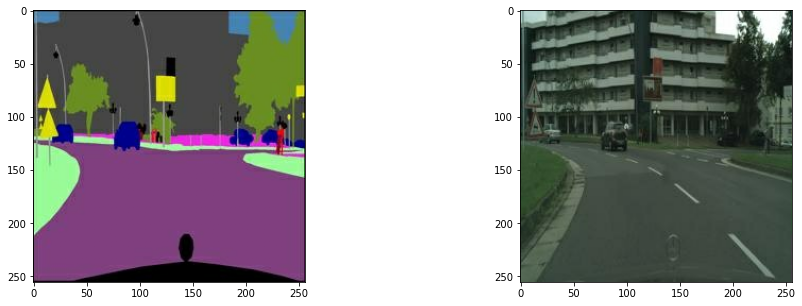

In [7]:
# visualize
fig, axes = plt.subplots(1,2, figsize = (16,5))
axes[0].imshow(x/255.0)
axes[1].imshow(y/255.0)

In [8]:
def normalize(input_image, real_image):
    input_image = (input_image / 127.5) - 1
    real_image = (real_image / 127.5) - 1
    return input_image, real_image

In [9]:
def resize(input_image, real_image):
    input_image = tf.image.resize(input_image, [IMAGE_SIZE, IMAGE_SIZE], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    real_image = tf.image.resize(real_image, [IMAGE_SIZE, IMAGE_SIZE], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    return input_image, real_image

In [10]:
def random_crop(input_image, real_image):
    stacked_image = tf.stack([input_image, real_image], axis = 0)
    cropped_image = tf.image.random_crop(stacked_image, size = [2, IMAGE_SIZE, IMAGE_SIZE, 3])
    return cropped_image[0], cropped_image[1]

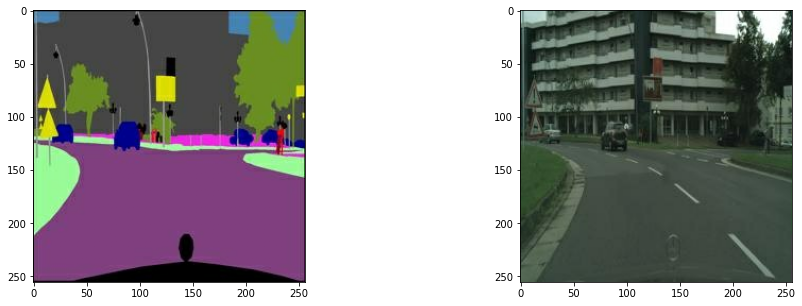

In [11]:
x_aug, y_aug = random_crop(x, y)
fig, axes = plt.subplots(1,2, figsize = (16,5))
axes[0].imshow(x_aug/255.0)
axes[1].imshow(y_aug/255.0)

In [12]:
def random_jitter(input_image, real_image):
    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        real_image = tf.image.flip_left_right(real_image)
    return input_image, real_image

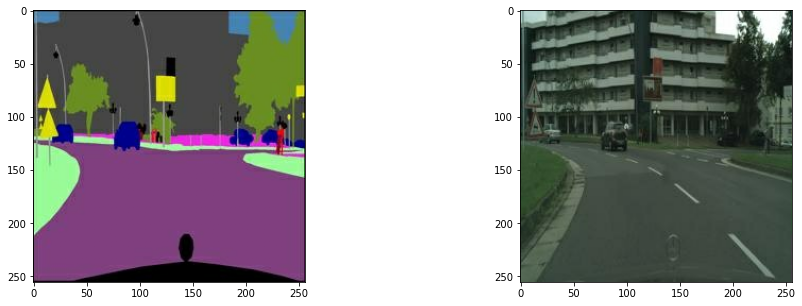

In [13]:
x_jit, y_jit = random_jitter(x, y)
fig, axes = plt.subplots(1,2, figsize = (16,5))
axes[0].imshow(x_jit/255.0)
axes[1].imshow(y_jit/255.0)

In [14]:
def load_train_images(image_path):
    input_image, real_image = load(image_path)
    input_image, real_image = resize(input_image, real_image)
    input_image, real_image = random_jitter(input_image, real_image)
    input_image, real_image = normalize(input_image, real_image)
    return input_image,real_image

In [15]:
def load_test_image(image_path):
    input_image, real_image = load(image_path)
    input_image, real_image = resize(input_image, real_image)
    input_image, real_image = normalize(input_image, real_image)
    return input_image, real_image

In [16]:
# create input pipeline
train_dataset = tf.data.Dataset.list_files(path + "train/*.jpg")
train_dataset = train_dataset.map(load_train_images)
train_dataset = train_dataset.shuffle(10).batch(BATCH_SIZE)
train_dataset

<BatchDataset shapes: ((None, 256, 256, 3), (None, 256, 256, 3)), types: (tf.float32, tf.float32)>

In [17]:
test_dataset = tf.data.Dataset.list_files(path + "val/*.jpg")
test_dataset = test_dataset.map(load_test_image)
test_dataset = test_dataset.batch(BATCH_SIZE)
test_dataset

<BatchDataset shapes: ((None, 256, 256, 3), (None, 256, 256, 3)), types: (tf.float32, tf.float32)>

In [18]:
# downsample block
def downsample(filters, size, batchnorm = True):
    init = tf.random_normal_initializer(0.,0.02)
    result = Sequential()
    result.add(Conv2D(filters, size, strides = 2, padding = "same", kernel_initializer = init, use_bias = False))
    if batchnorm == True:
        result.add(BatchNormalization())
        
    result.add(LeakyReLU())
    return result
down_model = downsample(3,4)
down_result = down_model(tf.expand_dims(x, axis = 0))
print(down_result.shape)

(1, 128, 128, 3)


In [19]:
# upsample block
def upsample(filters, size, dropout = False):
    init = tf.random_normal_initializer(0, 0.02)
    result = Sequential()
    result.add(Conv2DTranspose(filters, size, strides = 2, padding = "same", kernel_initializer = init, use_bias = False))
    result.add(BatchNormalization())
    if dropout == True:
        result.add(Dropout(0.5))
    result.add(ReLU())
    return result
up_model = upsample(3,4)
up_result = up_model(down_result)
print(up_result.shape)

(1, 256, 256, 3)


In [20]:
def generator():
    inputs = Input(shape = [IMAGE_SIZE, IMAGE_SIZE, 3])
    down_stack = [
        downsample(64, 4, batchnorm=False),
        downsample(128, 4),
        downsample(256, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4)
    ]
    
    
    up_stack = [
        upsample(512, 4, dropout=True),
        upsample(512, 4, dropout=True),
        upsample(512, 4),
        upsample(512, 4),
        upsample(256, 4),
        upsample(128, 4),
        upsample(64, 4),
    ]
    init = tf.random_normal_initializer(0., 0.02)
    last = Conv2DTranspose(3, 4, strides = 2, padding = "same", kernel_initializer = init, activation ="tanh")
    x = inputs
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)
    skips = reversed(skips[:-1])
    
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = Concatenate()([x, skip])
    
    x = last(x)
    return Model(inputs = inputs, outputs = x)

In [21]:
gen = generator()
gen.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
sequential_2 (Sequential)       (None, 128, 128, 64) 3072        input_1[0][0]                    
__________________________________________________________________________________________________
sequential_3 (Sequential)       (None, 64, 64, 128)  131584      sequential_2[0][0]               
__________________________________________________________________________________________________
sequential_4 (Sequential)       (None, 32, 32, 256)  525312      sequential_3[0][0]               
_______________________________________________________________________________________

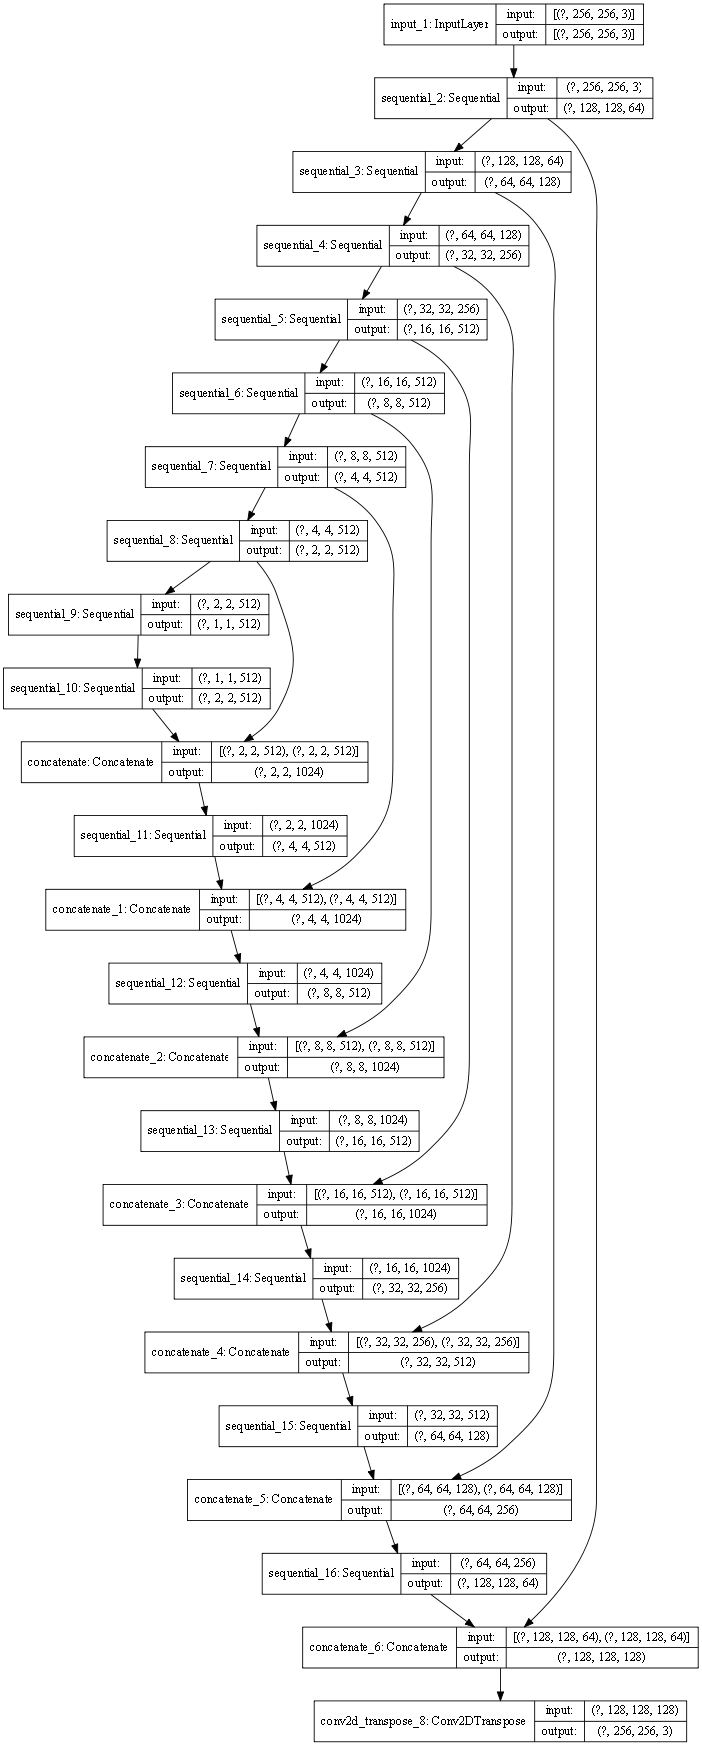

In [22]:
plot_model(gen, show_shapes=True, dpi = 64)

In [23]:
LAMBDA = 100

In [24]:
from keras.losses import BinaryCrossentropy
loss_function = BinaryCrossentropy(from_logits=True)

In [25]:
def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = loss_function(tf.ones_like(disc_generated_output), disc_generated_output)
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
    total_gen_loss = gan_loss + (LAMBDA * l1_loss)
    return total_gen_loss, gan_loss, l1_loss

In [26]:
def discriminator():
    init = tf.random_normal_initializer(0., 0.02)
    
    inp = Input(shape = [IMAGE_SIZE, IMAGE_SIZE, 3], name = "input_image")
    tar = Input(shape = [IMAGE_SIZE, IMAGE_SIZE, 3], name = "target_image")
    x = Concatenate()([inp, tar])
    down1 = downsample(64,4,False)(x)
    down2 = downsample(128, 4)(down1)
    down3 = downsample(256, 4)(down2)
    
    zero_pad1 = ZeroPadding2D()(down3)
    conv = Conv2D(256, 4, strides = 1, kernel_initializer = init, use_bias = False)(zero_pad1)
    leaky_relu = LeakyReLU()(conv)
    zero_pad2 = ZeroPadding2D()(leaky_relu)
    last = Conv2D(1, 4, strides = 1, kernel_initializer=init)(zero_pad2)
    return Model(inputs = [inp, tar], outputs = last)

In [27]:
disc = discriminator()
disc.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
target_image (InputLayer)       [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
concatenate_7 (Concatenate)     (None, 256, 256, 6)  0           input_image[0][0]                
                                                                 target_image[0][0]               
__________________________________________________________________________________________________
sequential_17 (Sequential)      (None, 128, 128, 64) 6144        concatenate_7[0][0]   

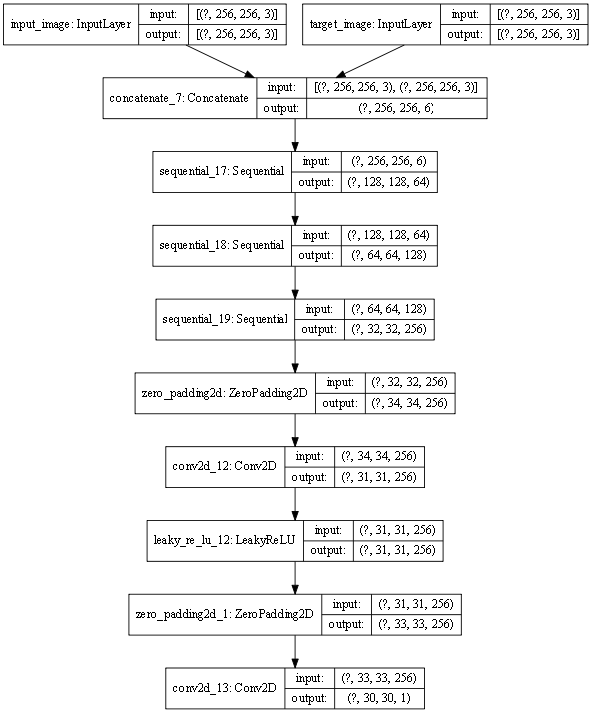

In [28]:
plot_model(disc, show_shapes=True, dpi = 64)

In [29]:
def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = loss_function(tf.ones_like(disc_real_output), disc_real_output)
    generated_loss = loss_function(tf.zeros_like(disc_generated_output), disc_generated_output)
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss

In [30]:
generator_optimizer = Adam(lr= 2e-4, beta_1=0.5)
discriminator_optimizer = Adam(lr = 2e-4, beta_1=0.5)

In [ ]:
def save_images(model, test_input, target, epoch):
    prediction = model(test_input, training= True)
    plt.figure(figsize = (15,15))
    display_list= [test_input[0], target[0], prediction[0]]
    title = ["Input Image", "Ground Truth", "Predicton Image"]
    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis("off")
    plt.savefig(f"output/epoch_{epoch}.jpg")
    plt.close()

In [ ]:
# make sure output directory exists to save images
if os.path.exists("output"):
    os.mkdir("output")

In [32]:
epochs = 150

In [33]:
@tf.function
def train_step(input_image, target, epoch):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = gen(input_image, training = True)
        
        disc_real_output = disc([input_image, target], training = True)
        disc_generated_output = disc([input_image, gen_output], training = True)
        gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)
        generator_gradients = gen_tape.gradient(gen_total_loss, gen.trainable_variables)
        discriminator_gradients = disc_tape.gradient(disc_loss, disc.trainable_variables)
        generator_optimizer.apply_gradients(zip(generator_gradients, gen.trainable_variables))
        discriminator_optimizer.apply_gradients(zip(discriminator_gradients, disc.trainable_variables))
        return gen_total_loss, disc_loss

In [37]:
def fit(train_ds, epochs, test_ds):
    for epoch in range(epochs):
        start = time.time()
        for input_, target in test_ds.take(1):
            save_images(gen, input_, target, epoch)
        # Train
        print(f"Epoch {epoch}")
        for n, (input_, target) in train_ds.enumerate():
            gen_loss, disc_loss = train_step(input_, target, epoch)
        print("Generator loss {:.2f} Discriminator loss {:.2f}".format(gen_loss, disc_loss))
        print("Time take for epoch {} is {} sec\n".format(epoch+1, time.time() - start))
        

In [38]:
import keras
keras.backend.clear_session()

In [ ]:
fit(train_dataset, epochs, test_dataset)

Epoch 0
Generator loss 29.86 Discriminator loss 3.21
Time take for epoch 1 is 486.6927375793457 sec

Epoch 1
Generator loss 27.67 Discriminator loss 0.23
Time take for epoch 2 is 475.5218040943146 sec

Epoch 2
